<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab4/blob/main/SP/Spectrum_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
import altair as alt
import pandas as pd

In [2]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A = 0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength > 750:
        wavelength = 750.
    if 380 <= wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif 490 <= wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif 580 <= wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R, G, B, A)

def rgb2hex(rgb):
    r = int(rgb[0] * 255)
    g = int(rgb[1] * 255)
    b = int(rgb[2] * 255)
    return f'#{r:02x}{g:02x}{b:02x}'


In [3]:
URL_H = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/hydrogen_1701237U1.TXT'
URL_Hg = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/mercury_1701237U1.TXT'
URL_He = 'https://raw.githubusercontent.com/evgeny-kolonsky/Lab4/refs/heads/main/SP/helium_1701237U1.TXT'

url = URL_Hg

wave_length, counts = np.loadtxt(url, delimiter=';', skiprows=8, usecols=[0,4], unpack=True)
peaks, _ = find_peaks(counts, height=200, prominence=100)

In [4]:
spectrum = pd.DataFrame({
    'wave_length': wave_length,
    'counts': counts
})
spectrum['color'] = spectrum.wave_length.apply(wavelength_to_rgb).apply( rgb2hex )

graph = alt.Chart(spectrum).mark_line().encode(
    x=alt.X('wave_length', scale=alt.Scale(domain=[400, 700])),
    y=alt.Y('counts'),
    tooltip=['wave_length', 'counts']
).interactive();

callout = alt.Chart(spectrum.iloc[peaks]).mark_point(
    color='red', size=200, tooltip="Tooltip text here"
).encode(
    x='wave_length',
    y='counts'
);

graph + callout

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

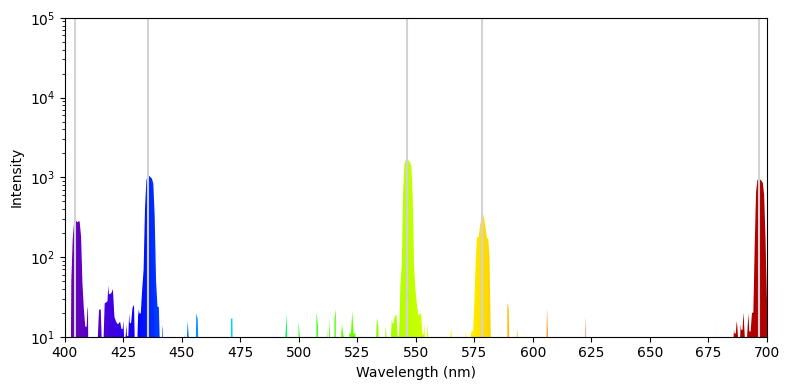

In [5]:
clim = (400, 700)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0], clim[1] + 1, 2)
colorlist = list(zip(norm(wl), [wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

wavelengths = spectrum['wave_length']
intensities = spectrum['counts']
#plt.plot(wavelengths, intensities, color='black', linewidth=1)

y = spectrum['counts']
X, Y = np.meshgrid(wavelengths, y)

extent = (np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim, extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.xticks(np.arange(400, 700+1, 25))
plt.ylabel('Intensity')

plt.fill_between(wavelengths, intensities, max(intensities), color='w')
plt.savefig('WavelengthColors.png', dpi=200)

plt.xlim(clim[0], clim[1])
#plt.plot(wave)
for peak in peaks:
  plt.axvline(wavelengths[peak], ymin=0, ymax=intensities[peak], color='lightgray')
plt.yscale('log')
plt.xlim(400, 700)
plt.ylim(1e1, 1e5)
plt.show()


In [6]:
for peak in peaks:
  wave = spectrum['wave_length'].iloc[peak]
  if wave < 400 or wave > 700:
    continue
  count = spectrum['counts'].iloc[peak]
  power = np.log(count) / np.log(10)

  print(f'Wavelength {wave:.0f} nm power {power:.1f} ')


Wavelength 404 nm power 2.5 
Wavelength 436 nm power 3.0 
Wavelength 546 nm power 3.2 
Wavelength 578 nm power 2.5 
Wavelength 697 nm power 3.0 
